In [1]:
!kaggle datasets download brendan45774/test-file -p {"./data"}

Dataset URL: https://www.kaggle.com/datasets/brendan45774/test-file
License(s): CC0-1.0




  0%|          | 0.00/11.2k [00:00<?, ?B/s]
100%|██████████| 11.2k/11.2k [00:00<00:00, 37.5kB/s]
100%|██████████| 11.2k/11.2k [00:01<00:00, 10.4kB/s]


In [4]:
from dotenv import load_dotenv
import zipfile
import os

load_dotenv(".env")

path_zipfile = os.path.join(os.getenv("DATA_DIRECTORY"), "test-file.zip")
extract_directory = os.getenv("DATA_DIRECTORY")

with zipfile.ZipFile(path_zipfile, 'r') as zip_file:
    zip_file.extractall(extract_directory)

# Import Libraries

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import optuna
from optuna.samplers import TPESampler
from sklearn.compose import make_column_selector, ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

# Load Data

In [42]:
df = pd.read_csv("data/tested.csv")

In [43]:
X = df.drop('Survived', axis = 1)
y = df['Survived']

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [45]:
X.drop(columns = ['PassengerId', 'Name', 'Cabin', 'Ticket'], inplace = True)

In [46]:
X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [47]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.0,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.0,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.0,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292


In [48]:
X.describe(include = "object").T

,count,unique,top,freq
Sex,418,2,male,266
Embarked,418,3,S,270


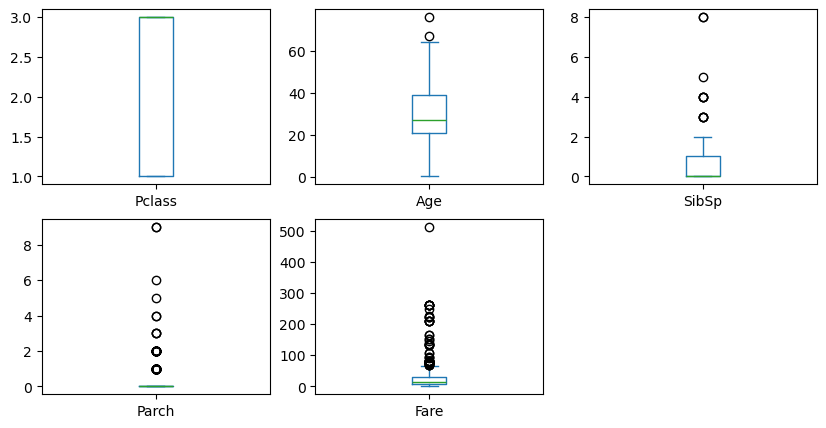

In [50]:
X.plot(kind = "box", subplots = True, layout = (2, 3), figsize = (10, 5))
plt.show()

In [51]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy = "mean"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown= "ignore")
)

In [52]:
preprocessor = ColumnTransformer([
    ("num", num_pipeline, ["Age", "Fare"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include = object))
    ],
    remainder= "passthrough"
)

In [54]:
data = preprocessor.fit_transform(X)

In [55]:
data = pd.DataFrame(data, columns = preprocessor.get_feature_names_out())

In [57]:
X = data.copy()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size = 0.2)

# Models

## Random Forest Classifier

In [59]:
randomforest_classifier = RandomForestClassifier(random_state= 42, max_depth = 10, n_estimators = 100)

In [60]:
randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [61]:
y_pred = randomforest_classifier.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred)

1.0

## Logistic Regression

In [63]:
logistic_regression = LogisticRegression(random_state= 42, max_iter = 1000, C = 0.5)

In [64]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=1000, random_state=42)

In [65]:
y_pred = logistic_regression.predict(X_test)

In [66]:
accuracy_score(y_test, y_pred)

1.0

# Optimizer

## Random Forest

In [67]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = 10)

[I 2024-11-26 16:21:05,122] A new study created in memory with name: no-name-16494c03-78ae-4342-85d0-6646f275f789
[I 2024-11-26 16:21:05,442] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 49, 'max_depth': 2}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:21:06,364] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 172, 'max_depth': 31}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:21:06,886] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 84, 'max_depth': 7}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:21:07,100] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 13, 'max_depth': 29}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:21:08,128] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 152, 'max_depth': 32}. Best is trial 0 with value: 1.0.
[I 2024-11-26 16:21:08,381] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 42, 'max_depth': 3}. Best is trial 0 with value

In [68]:
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

Best hyperparameters:  {'n_estimators': 49, 'max_depth': 2}
Best accuracy:  1.0


## Logistic Regression

In [88]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 10)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        random_state=42,
        max_iter=10
    )

    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = 10)

[I 2024-11-26 16:24:15,978] A new study created in memory with name: no-name-d11424b6-f54c-41fa-906c-9939595f079c
C:\Users\HP\AppData\Local\Temp\ipykernel_30460\1576925631.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 10)
c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2024-11-26 16:24:16

In [82]:
# Mostrar los mejores hiperparámetros
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

Best hyperparameters:  {'C': 0.3614897661990446, 'solver': 'saga', 'penalty': 'l2'}
Best accuracy:  1.0


**Conclusión:** Se puede visualizar que agregando componentes de penalidad al modelo de Regresión Logistica se logra un porcentaje de 93.7% en la iteración 7. A pesar de que su rendimiento es inferior al mostrado por Random Forest (100%), esto nos permite que el modelo sea capaz de generalizar los nuevos datos de entrada, ya que no se está adaptando completamente a los datos de entrenamiento. Por eso, el modelo de regresión logistica será el modelo que se llevará a *producción*.

In [94]:
best_logistic_regression = LogisticRegression(
    C= 0.01765221403950056,
    solver= 'saga',
    penalty= 'l2',
    random_state=42,
    max_iter=1000
)

In [95]:
best_logistic_regression.fit(X_train, y_train)

LogisticRegression(C=0.01765221403950056, max_iter=1000, random_state=42,
                   solver='saga')

In [96]:
y_pred = best_logistic_regression.predict(X_test)

In [97]:
accuracy_score(y_test, y_pred)

1.0

# Save Code

In [98]:
# Save model
joblib.dump(best_logistic_regression, "model.joblib")

['model.joblib']

In [99]:
# Save pipeline 
joblib.dump(preprocessor, "pipeline.joblib")

['pipeline.joblib']